# Homework 08


In [1]:
import sys
!{sys.executable} -m pip install sklearn
from sklearn.manifold import TSNE
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from training import training
from visualize import show_dataset_examples, plot_results

## 1. Dataset

In [2]:
(train_ds, valid_ds, test_ds), mnist_info = tfds.load(
    'mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True)

datasets_unprocessed = {
    'train': train_ds,
    'valid': valid_ds,
    'test': test_ds
}

In [3]:
def salt_pepper(img, level) -> tf.Tensor:
    """Apply salt-and-pepper noise to img.
    
    :param img: image that salt and pepper should be applied to
    :type img: tf.Tensor
    :param level: proportion of image to be filled with salt/pepper
    :type level: float
    :return: salt-and-peppered image
    :rtype: tf.Tensor
    """
    # value range of pixels in img
    max_value = tf.math.reduce_max(img)
    min_value = tf.math.reduce_min(img)
    val_range = -(min_value - max_value)
    # number of pixels in image
    N = tf.cast(tf.size(img), tf.float32)
    # amount of salt-and-pepper pixels in final image
    K = N * level
    N, K = tf.cast(N, tf.int32), tf.cast(K, tf.int32)
    # create tensors containing our salt and pepper
    salt = tf.ones((int(tf.math.floor(K/2)))) * val_range
    pepper = tf.ones((int(tf.math.ceil(K/2)))) * -val_range
    salt_pepper_tensor = tf.concat([tf.zeros((N-K)), salt, pepper], axis=0)
    # shuffle and reshape
    sp_noise = tf.random.shuffle(salt_pepper_tensor)
    sp_noise = tf.reshape(sp_noise, tf.shape(img))
    # apply salt and pepper
    spiced_img = img + sp_noise
    # clip back into the original range
    spiced_img = tf.clip_by_value(spiced_img, min_value, max_value)
    return spiced_img

In [4]:
def gaussian_noise(img, level) -> tf.Tensor:
    """Apply gaussian noise to img.
    
    :param img: image that gaussian noise should be applied to
    :type img: tf.Tensor
    :param level: proportion of image to be filled with salt/pepper
    :type level: float
    :return: salt-and-peppered image
    :rtype: tf.Tensor
    """
    # value range of pixels in img
    max_value = tf.math.reduce_max(img)
    min_value = tf.math.reduce_min(img)
    # create noise tensor
    noise = tf.random.normal((tf.shape(img))) * level
    # add noise to img
    gaussian_img = img + noise
    # clip back into the original range
    gaussian_img = tf.clip_by_value(gaussian_img, min_value, max_value)
    return gaussian_img

In [5]:
def preprocessing_pipeline(data, salt_pepper_level=0, gaussian_noise_level=0):
    # function that applies salt-and-pepper and gaussian noise to an image
    apply_noise = lambda img: salt_pepper(
                                  gaussian_noise(img, gaussian_noise_level),
                                  salt_pepper_level)
    data = data.map(lambda image, _: (apply_noise(image/255), image/255))#(apply_noise(image/128-1), image/128-1))
    # cache the dataset
    data = data.cache()
    # shuffle, batch and prefetch the dataset
    data = data.shuffle(1000)
    data = data.batch(12)
    data = data.prefetch(300)
    return data

In [6]:
SALT_PEPPER_LEVEL = 0.05
GAUSSIAN_NOISE_LEVEL = 0.2
datasets = {
        key:preprocessing_pipeline(ds, SALT_PEPPER_LEVEL, GAUSSIAN_NOISE_LEVEL)
    for key, ds in datasets_unprocessed.items()
}

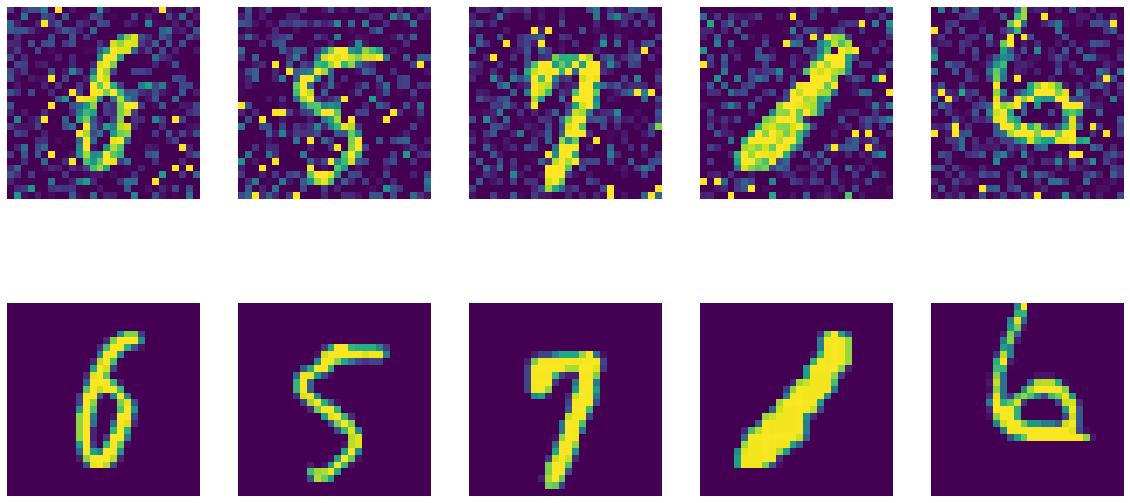

In [7]:
show_dataset_examples(datasets['train'])

## 2. Model

### 2.1 Convolutional Autoencoder

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self, output_units) -> None:
        super(Encoder, self).__init__()
        self.layer_list = [
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(output_units)
        ]
    
    def call(self, input_):
        x = input_
        for layer in self.layer_list:
            x = layer(x)
        return x

class Decoder(tf.keras.Model):
    def __init__(self) -> None:
        super(Decoder, self).__init__()
        self.layer_list = [
            tf.keras.layers.Dense(49),
            tf.keras.layers.Reshape((7,7,1)),
            tf.keras.layers.Conv2DTranspose(8,3,2,padding='same'),
            tf.keras.layers.Conv2DTranspose(1,3,2,padding='same')
            #tf.keras.layers.Conv2DTranspose(1,3,2,padding='same')
        ]
        '''
        self.layer_list = [
            #tf.keras.layers.Dense(49),
            #tf.keras.layers.Reshape((7,7,1)),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'),
            tf.keras.layers.UpSampling2D(2),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'),
            tf.keras.layers.UpSampling2D(2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
            tf.keras.layers.UpSampling2D(2),
            tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
        ]'''
    
    def call(self, input_):
        x = input_
        for layer in self.layer_list:
            x = layer(x)
        return x



class ConvolutionalAutoencoder(tf.keras.Model):
    def __init__(self) -> None:
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = Encoder(7)
        self.decoder = Decoder()
    
    def call(self, input_):
        latent_space = self.encoder(input_)
        output = self.decoder(latent_space)
        return output


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  160       
                                                                 
 conv2d_1 (Conv2D)           multiple                  1160      
                                                                 
 conv2d_2 (Conv2D)           multiple                  584       
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  903       
                                                                 
Total params: 2,807
Trainable params: 2,807
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
________________________________________

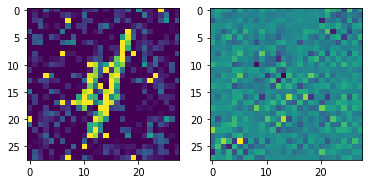

In [9]:
ae = ConvolutionalAutoencoder()
ae.build((None, 28,28,1))
ae.encoder.summary()
ae.decoder.summary()

for i, t in datasets['train'].take(1):
    o = ae(i)
    plt.subplot(1,2,1)
    plt.imshow(i[0][:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(o[0][:,:,0])


    

In [10]:
model = ConvolutionalAutoencoder()
# Initialize the loss-function
loss_func = tf.keras.losses.MeanSquaredError() #CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(0.1)
#optimizer = tf.keras.optimizers.Adam(0.0001)

# Train our LSTM-Model using datasets, loss_func and the optimizer
losses, accuracies = training(model, datasets, loss_func, optimizer, epochs=10)

Epoch 1 starting with valid. accuracy: 0.576 and loss: 0.1120000034570694
Epoch 2 starting with valid. accuracy: 0.054 and loss: 0.05999999865889549
Epoch 3 starting with valid. accuracy: 0.059 and loss: 0.052000001072883606
Epoch 4 starting with valid. accuracy: 0.073 and loss: 0.04899999871850014
Epoch 5 starting with valid. accuracy: 0.084 and loss: 0.04800000041723251
Epoch 6 starting with valid. accuracy: 0.09 and loss: 0.04699999839067459
Epoch 7 starting with valid. accuracy: 0.1 and loss: 0.04600000008940697
Epoch 8 starting with valid. accuracy: 0.113 and loss: 0.04500000178813934
Epoch 9 starting with valid. accuracy: 0.118 and loss: 0.04500000178813934
Epoch 10 starting with valid. accuracy: 0.12 and loss: 0.04500000178813934


In [11]:

import numpy as np
embeddings = []
targets = []
for inp, target in datasets_unprocessed['test'].map(lambda x,t:(x/255, t)).shuffle(100).batch(10).take(1000):
    output = model.encoder(inp)
    embeddings.append(output[0])
    targets.append(target[0])



X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.array(embeddings))



1000 1000 1000


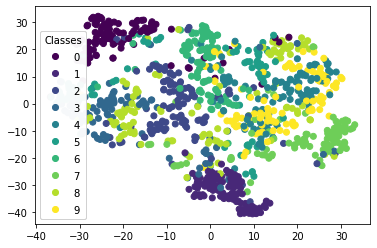

In [12]:
x,y = np.split(X_embedded, 2, axis=1)
print(len(x), len(y), len(targets))
targets = np.reshape(np.array(targets), (1000,1))


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=targets)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

We can see the typical problem with non-variational autoencoders that the latent space is not densely packed.

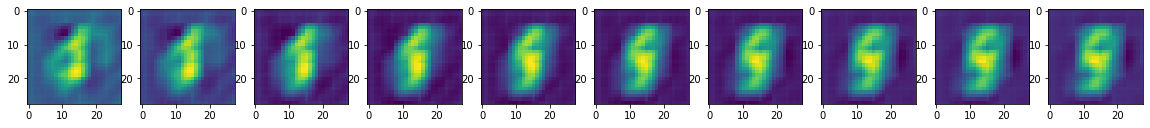

In [13]:
# interpolate between two random embeddings
a = embeddings[0]
b = embeddings[1]

def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

interpolations = interpolate_points(a,b)

fig, axs = plt.subplots(1, 10)
fig.set_size_inches(20, 9)

outputs = model.decoder(interpolations)

for i, out in enumerate(outputs):
    axs[i].imshow(out[:,:,0])


0.5408163265306123


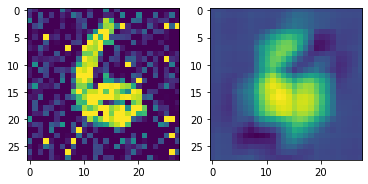

In [14]:
import numpy as np
for i, t in datasets['test'].take(1):
    o = model(i)
    print(np.mean(np.round(o,1) == np.round(t,1)))
    plt.subplot(1,2,1)
    plt.imshow(i[0][:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(o[0][:,:,0])